# Introduction
The data, which is machine-generated, encompasses user registration information from September 2019 and tracks customer activities and order history until October 2020.

This dataset is comprehensive, covering various aspects of customer interactions, including the date and country of registration, the total number of orders made (broken down into delivery and takeaway), the timings of purchases (whether they're made during breakfast, lunch, or dinner), and the preferred restaurant types. It also captures details about customers' favorite purchase platform (Web or Android), and even the average distance for food delivery.

In this analysis, I will be diving deep into this dataset to uncover patterns in customer behavior and preferences. My main objective is to segment the users based on their interaction with the service. The outcome of this segmentation will be invaluable to the marketing team, as it will enable them to devise targeted campaigns to re-engage different customer segments.

So, without further ado, let's load the data and begin our exploratory data analysis.

# Data Loading and Exploration

In [225]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import json
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter

In [144]:
# Loading the data
data = pd.read_csv('dataset_for_analyst_assignment_20201120.csv')  # Replace 'data.csv' with your csv file path

# Display the first few rows of the data
data.head()

REGISTRATION_DATE REGISTRATION_COUNTRY  PURCHASE_COUNT  \
0  2019-09-01 00:00:00.000                  DNK               0   
1  2019-09-01 00:00:00.000                  FIN               1   
2  2019-09-01 00:00:00.000                  DNK              19   
3  2019-09-01 00:00:00.000                  FIN               0   
4  2019-09-01 00:00:00.000                  GRC               0   

   PURCHASE_COUNT_DELIVERY  PURCHASE_COUNT_TAKEAWAY       FIRST_PURCHASE_DAY  \
0                      NaN                      NaN                      NaN   
1                      1.0                      0.0  2020-09-02 00:00:00.000   
2                     19.0                      0.0  2019-12-10 00:00:00.000   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   

         LAST_PURCHASE_DAY  USER_ID  BREAKFAST_PURCHASES  LUNCH_PURCHASES  \
0                      NaN        1                  NaN              NaN   
1  2020-09-02 00:00:00.000        2                  0.0              1.0   
2  2020-05-25 00:00:00.000        3                  0.0              4.0   
3                      NaN        4                  NaN              NaN   
4                      NaN        5                  NaN              NaN   

   ...  WEB_PURCHASES  ANDROID_PURCHASES  PREFERRED_RESTAURANT_TYPES  \
0  ...            NaN                NaN                         NaN   
1  ...            0.0                1.0                         NaN   
2  ...           19.0                0.0                         NaN   
3  ...            NaN                NaN                         NaN   
4  ...            NaN                NaN                         NaN   

   USER_HAS_VALID_PAYMENT_METHOD  MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE  \
0                          False                                      NaN   
1                          False                                     23.0   
2                           True                                     21.0   
3                          False                                      NaN   
4                          False                                      NaN   

   MOST_COMMON_WEEKDAY_TO_PURCHASE  AVG_DAYS_BETWEEN_PURCHASES  \
0                              NaN                         NaN   
1                              2.0                         NaN   
2                              2.0                         9.0   
3                              NaN                         NaN   
4                              NaN                         NaN   

   MEDIAN_DAYS_BETWEEN_PURCHASES AVERAGE_DELIVERY_DISTANCE_KMS  \
0                            NaN                           NaN   
1                            NaN                         6.853   
2                            3.0                         6.559   
3                            NaN                           NaN   
4                            NaN                           NaN   

                        PURCHASE_COUNT_BY_STORE_TYPE  
0  {\n  "General merchandise": 0,\n  "Grocery": 0...  
1  {\n  "General merchandise": 0,\n  "Grocery": 0...  
2  {\n  "General merchandise": 1,\n  "Grocery": 9...  
3  {\n  "General merchandise": 0,\n  "Grocery": 0...  
4  {\n  "General merchandise": 0,\n  "Grocery": 0...  

[5 rows x 30 columns]

In [145]:
# Overview of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21983 entries, 0 to 21982
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   REGISTRATION_DATE                        21983 non-null  object 
 1   REGISTRATION_COUNTRY                     21983 non-null  object 
 2   PURCHASE_COUNT                           21983 non-null  int64  
 3   PURCHASE_COUNT_DELIVERY                  12028 non-null  float64
 4   PURCHASE_COUNT_TAKEAWAY                  12028 non-null  float64
 5   FIRST_PURCHASE_DAY                       11964 non-null  object 
 6   LAST_PURCHASE_DAY                        12027 non-null  object 
 7   USER_ID                                  21983 non-null  int64  
 8   BREAKFAST_PURCHASES                      12028 non-null  float64
 9   LUNCH_PURCHASES                          12028 non-null  float64
 10  EVENING_PURCHASES                        12028

In [146]:
# Converting to datetime
data['REGISTRATION_DATE'] = pd.to_datetime(data['REGISTRATION_DATE'])
data['FIRST_PURCHASE_DAY'] = pd.to_datetime(data['FIRST_PURCHASE_DAY'])
data['LAST_PURCHASE_DAY'] = pd.to_datetime(data['LAST_PURCHASE_DAY'])

# Converting to category
data['REGISTRATION_COUNTRY'] = data['REGISTRATION_COUNTRY'].astype('category')
data['PREFERRED_DEVICE'] = data['PREFERRED_DEVICE'].astype('category')

# Setting 'USER_ID' as index
data.set_index('USER_ID', inplace=True)


In [147]:
# Descriptive statistics
data.describe().T

count        mean         std  \
PURCHASE_COUNT                           21983.0    3.345358    8.523171   
PURCHASE_COUNT_DELIVERY                  12028.0    5.741686   10.536220   
PURCHASE_COUNT_TAKEAWAY                  12028.0    0.372464    1.416310   
BREAKFAST_PURCHASES                      12028.0    0.193964    1.104067   
LUNCH_PURCHASES                          12028.0    2.375042    5.626178   
EVENING_PURCHASES                        12028.0    0.493432    1.827710   
DINNER_PURCHASES                         12028.0    3.029016    5.238209   
LATE_NIGHT_PURCHASES                     12028.0    0.000000    0.000000   
TOTAL_PURCHASES_EUR                      12028.0  176.210419  299.086986   
DISTINCT_PURCHASE_VENUE_COUNT            12028.0    3.319671    3.766418   
MIN_PURCHASE_VALUE_EUR                   12028.0   24.428312   18.914771   
MAX_PURCHASE_VALUE_EUR                   12028.0   42.068043   41.176221   
AVG_PURCHASE_VALUE_EUR                   12028.0   31.195060   20.716542   
IOS_PURCHASES                            12028.0    2.900482    7.456288   
WEB_PURCHASES                            12028.0    1.056535    4.776431   
ANDROID_PURCHASES                        12028.0    2.157133    6.876314   
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE  12028.0   11.501995    6.930837   
MOST_COMMON_WEEKDAY_TO_PURCHASE          12028.0    4.010392    2.010071   
AVG_DAYS_BETWEEN_PURCHASES                7832.0   64.293539   72.570103   
MEDIAN_DAYS_BETWEEN_PURCHASES             7832.0   55.792135   74.963336   
AVERAGE_DELIVERY_DISTANCE_KMS            12028.0    5.961218    3.466263   

                                           min      25%     50%      75%  \
PURCHASE_COUNT                           0.000   0.0000   1.000    3.000   
PURCHASE_COUNT_DELIVERY                  0.000   1.0000   2.000    6.000   
PURCHASE_COUNT_TAKEAWAY                  0.000   0.0000   0.000    0.000   
BREAKFAST_PURCHASES                      0.000   0.0000   0.000    0.000   
LUNCH_PURCHASES                          0.000   0.0000   1.000    2.000   
EVENING_PURCHASES                        0.000   0.0000   0.000    0.000   
DINNER_PURCHASES                         0.000   0.0000   1.000    3.000   
LATE_NIGHT_PURCHASES                     0.000   0.0000   0.000    0.000   
TOTAL_PURCHASES_EUR                      1.012  32.3840  75.900  196.328   
DISTINCT_PURCHASE_VENUE_COUNT            1.000   1.0000   2.000    4.000   
MIN_PURCHASE_VALUE_EUR                   0.000  14.1960  19.266   29.406   
MAX_PURCHASE_VALUE_EUR                   1.016  23.3680  35.560   51.816   
AVG_PURCHASE_VALUE_EUR                   1.012  19.2280  27.324   38.456   
IOS_PURCHASES                            0.000   0.0000   0.000    2.000   
WEB_PURCHASES                            0.000   0.0000   0.000    1.000   
ANDROID_PURCHASES                        0.000   0.0000   0.000    1.000   
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE  0.000   5.0000  11.500   18.000   
MOST_COMMON_WEEKDAY_TO_PURCHASE          1.000   2.0000   4.000    6.000   
AVG_DAYS_BETWEEN_PURCHASES               0.000  18.0000  39.500   81.000   
MEDIAN_DAYS_BETWEEN_PURCHASES            0.000  10.0000  25.000   68.250   
AVERAGE_DELIVERY_DISTANCE_KMS            0.002   2.9505   5.928    8.978   

                                              max  
PURCHASE_COUNT                            320.000  
PURCHASE_COUNT_DELIVERY                   320.000  
PURCHASE_COUNT_TAKEAWAY                    44.000  
BREAKFAST_PURCHASES                        52.000  
LUNCH_PURCHASES                           171.000  
EVENING_PURCHASES                          71.000  
DINNER_PURCHASES                          104.000  
LATE_NIGHT_PURCHASES                        0.000  
TOTAL_PURCHASES_EUR                      7979.620  
DISTINCT_PURCHASE_VENUE_COUNT              71.000  
MIN_PURCHASE_VALUE_EUR                    659.100  
MAX_PURCHASE_VALUE_EUR                   3048.000  
AVG_PURCHASE_VALUE_EU

### Summary of Initial Data Exploration

The descriptive statistics of the numerical columns in the data provide us a lot of useful insights. Here's a summary of the dataset:

- We have 21,983 users, with varying purchase behavior. The average user makes approximately 3.34 purchases, with some users making up to 320 purchases.

- The 'PURCHASE_COUNT_DELIVERY' and 'PURCHASE_COUNT_TAKEAWAY' columns suggest that users prefer delivery over takeaway, with average delivery orders of approximately 5.74 compared to 0.37 for takeaway.

- As for the time of day when purchases are made, lunch and dinner seem to be the most popular times for users to make purchases, with an average of approximately 2.38 and 3.03 purchases respectively. There are very few breakfast orders, and no late-night orders in the dataset.

- The 'TOTAL_PURCHASES_EUR' column shows that the average total amount spent by a user is about 176.21 EUR, with some users spending up to 7,979.62 EUR.

- There's an average of 3.32 unique purchase venues per user, indicating that users tend to order from a variety of places.

- Most of the purchases seem to be made through the iOS platform (about 2.90 orders per user), followed by Android (about 2.16 orders per user), and Web (about 1.06 orders per user).

- The most common time of the day for purchases seems to be around 11:50 AM and the most common day of the week for purchases is the 4th day (Wednesday, if Monday is considered the first day).

- On average, users have their purchases delivered over a distance of approximately 5.96 km, with some deliveries covering up to 11.999 km.

Looking at these figures, it's clear that there are variations in the data. It's also evident that some values seem to be missing, as seen from the counts. We'll handle these in the next stage: Data Cleaning.

# Data Cleaning
## Handling Missing Values
The first step in the data cleaning process is to handle the missing values. Let's first check the number of missing values in each column:

In [148]:
# Check missing values
missing_values = data.isnull().sum()
print(missing_values)


REGISTRATION_DATE                              0
REGISTRATION_COUNTRY                           0
PURCHASE_COUNT                                 0
PURCHASE_COUNT_DELIVERY                     9955
PURCHASE_COUNT_TAKEAWAY                     9955
FIRST_PURCHASE_DAY                         10019
LAST_PURCHASE_DAY                           9956
BREAKFAST_PURCHASES                         9955
LUNCH_PURCHASES                             9955
EVENING_PURCHASES                           9955
DINNER_PURCHASES                            9955
LATE_NIGHT_PURCHASES                        9955
TOTAL_PURCHASES_EUR                         9955
DISTINCT_PURCHASE_VENUE_COUNT               9955
MIN_PURCHASE_VALUE_EUR                      9955
MAX_PURCHASE_VALUE_EUR                      9955
AVG_PURCHASE_VALUE_EUR                      9955
PREFERRED_DEVICE                              73
IOS_PURCHASES                               9955
WEB_PURCHASES                               9955
ANDROID_PURCHASES   

- For columns related to purchase details (`PURCHASE_COUNT_DELIVERY`, `PURCHASE_COUNT_TAKEAWAY`, `BREAKFAST_PURCHASES`, `LUNCH_PURCHASES`, `EVENING_PURCHASES`, `DINNER_PURCHASES`, `LATE_NIGHT_PURCHASES`, `TOTAL_PURCHASES_EUR`, `DISTINCT_PURCHASE_VENUE_COUNT`, `MIN_PURCHASE_VALUE_EUR`, `MAX_PURCHASE_VALUE_EUR`, `AVG_PURCHASE_VALUE_EUR`, `IOS_PURCHASES`, `WEB_PURCHASES`, `ANDROID_PURCHASES`, `MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE`, `MOST_COMMON_WEEKDAY_TO_PURCHASE`, `AVG_DAYS_BETWEEN_PURCHASES`, `MEDIAN_DAYS_BETWEEN_PURCHASES`, `AVERAGE_DELIVERY_DISTANCE_KMS`): Given the context, it would be reasonable to assume that missing values mean the user did not make any purchases. Therefore, we can fill the missing values with 0.

- For `PREFERRED_DEVICE`: As this is a categorical variable, we could either fill the missing values with the mode (most common category), or we could introduce a new category, such as 'Unknown'.

- For `FIRST_PURCHASE_DAY` and `LAST_PURCHASE_DAY`: These are tricky because filling them with an arbitrary date could introduce bias. One approach could be to fill them with the registration date assuming that users without a first purchase date did not make any purchases since registering. However, it is important to double-check this approach depending on the specific use case.

- For `PREFERRED_RESTAURANT_TYPES`: This column has a large number of missing values. It could mean that most users don't have a preferred restaurant type. On my case, it would be better to handle this in different ways, e.g., filling with 'No preference', or even dropping this column if it's not very useful for the analysis.

In [149]:
# Fill purchase related columns with 0
purchase_columns = ['PURCHASE_COUNT_DELIVERY', 'PURCHASE_COUNT_TAKEAWAY', 'BREAKFAST_PURCHASES', 
                   'LUNCH_PURCHASES', 'EVENING_PURCHASES', 'DINNER_PURCHASES', 
                   'LATE_NIGHT_PURCHASES', 'TOTAL_PURCHASES_EUR', 'DISTINCT_PURCHASE_VENUE_COUNT', 
                   'MIN_PURCHASE_VALUE_EUR', 'MAX_PURCHASE_VALUE_EUR', 'AVG_PURCHASE_VALUE_EUR', 
                   'IOS_PURCHASES', 'WEB_PURCHASES', 'ANDROID_PURCHASES', 
                   'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE', 'MOST_COMMON_WEEKDAY_TO_PURCHASE', 
                   'AVG_DAYS_BETWEEN_PURCHASES', 'MEDIAN_DAYS_BETWEEN_PURCHASES', 
                   'AVERAGE_DELIVERY_DISTANCE_KMS']
data[purchase_columns] = data[purchase_columns].fillna(0)

# Add 'Unknown' as a category for 'PREFERRED_DEVICE'
data['PREFERRED_DEVICE'] = data['PREFERRED_DEVICE'].cat.add_categories('Unknown')

# Now fill missing values with 'Unknown'
data['PREFERRED_DEVICE'] = data['PREFERRED_DEVICE'].fillna('Unknown')

# Fill 'FIRST_PURCHASE_DAY' and 'LAST_PURCHASE_DAY' with 'REGISTRATION_DATE'
data['FIRST_PURCHASE_DAY'] = data['FIRST_PURCHASE_DAY'].fillna(data['REGISTRATION_DATE'])
data['LAST_PURCHASE_DAY'] = data['LAST_PURCHASE_DAY'].fillna(data['REGISTRATION_DATE'])

# Fill 'PREFERRED_RESTAURANT_TYPES' with 'No preference'
data['PREFERRED_RESTAURANT_TYPES'] = data['PREFERRED_RESTAURANT_TYPES'].fillna('No preference')


In [150]:
data.describe().T

count       mean         std  min  \
PURCHASE_COUNT                           21983.0   3.345358    8.523171  0.0   
PURCHASE_COUNT_DELIVERY                  21983.0   3.141564    8.301007  0.0   
PURCHASE_COUNT_TAKEAWAY                  21983.0   0.203794    1.063899  0.0   
BREAKFAST_PURCHASES                      21983.0   0.106127    0.822346  0.0   
LUNCH_PURCHASES                          21983.0   1.299504    4.326257  0.0   
EVENING_PURCHASES                        21983.0   0.269981    1.374056  0.0   
DINNER_PURCHASES                         21983.0   1.657326    4.157648  0.0   
LATE_NIGHT_PURCHASES                     21983.0   0.000000    0.000000  0.0   
TOTAL_PURCHASES_EUR                      21983.0  96.413543  237.983688  0.0   
DISTINCT_PURCHASE_VENUE_COUNT            21983.0   1.816358    3.239167  0.0   
MIN_PURCHASE_VALUE_EUR                   21983.0  13.365953   18.536758  0.0   
MAX_PURCHASE_VALUE_EUR                   21983.0  23.017532   36.961648  0.0   
AVG_PURCHASE_VALUE_EUR                   21983.0  17.068379   21.816161  0.0   
IOS_PURCHASES                            21983.0   1.586999    5.701134  0.0   
WEB_PURCHASES                            21983.0   0.578083    3.571970  0.0   
ANDROID_PURCHASES                        21983.0   1.180276    5.198396  0.0   
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE  21983.0   6.293318    7.685281  0.0   
MOST_COMMON_WEEKDAY_TO_PURCHASE          21983.0   2.194286    2.489147  0.0   
AVG_DAYS_BETWEEN_PURCHASES               21983.0  22.906200   53.143306  0.0   
MEDIAN_DAYS_BETWEEN_PURCHASES            21983.0  19.877360   52.113803  0.0   
AVERAGE_DELIVERY_DISTANCE_KMS            21983.0   3.261681    3.921630  0.0   

                                         25%     50%      75%       max  
PURCHASE_COUNT                           0.0   1.000   3.0000   320.000  
PURCHASE_COUNT_DELIVERY                  0.0   1.000   3.0000   320.000  
PURCHASE_COUNT_TAKEAWAY                  0.0   0.000   0.0000    44.000  
BREAKFAST_PURCHASES                      0.0   0.000   0.0000    52.000  
LUNCH_PURCHASES                          0.0   0.000   1.0000   171.000  
EVENING_PURCHASES                        0.0   0.000   0.0000    71.000  
DINNER_PURCHASES                         0.0   0.000   1.0000   104.000  
LATE_NIGHT_PURCHASES                     0.0   0.000   0.0000     0.000  
TOTAL_PURCHASES_EUR                      0.0  16.192  87.5380  7979.620  
DISTINCT_PURCHASE_VENUE_COUNT            0.0   1.000   2.0000    71.000  
MIN_PURCHASE_VALUE_EUR                   0.0   8.112  21.2940   659.100  
MAX_PURCHASE_VALUE_EUR                   0.0  14.224  37.5920  3048.000  
AVG_PURCHASE_VALUE_EUR                   0.0  12.144  29.3480   657.800  
IOS_PURCHASES                            0.0   0.000   1.0000   200.000  
WEB_PURCHASES                            0.0   0.000   0.0000   196.000  
ANDROID_PURCHASES                        0.0   0.000   0.0000   221.000  
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE  0.0   2.000  13.0000    23.000  
MOST_COMMON_WEEKDAY_TO_PURCHASE          0.0   1.000   4.0000     7.000  
AVG_DAYS_BETWEEN_PURCHASES               0.0   0.000  21.0000   421.000  
MEDIAN_DAYS_BETWEEN_PURCHASES            0.0   0.000  12.0000   421.000  
AVERAGE_DELIVERY_DISTANCE_KMS            0.0   1.023   6.4615    11.999

Missing data was identified in multiple columns, particularly the columns related to purchases and the preferred device.

For purchase related columns, I filled missing data with zero, operating under the assumption that if the purchase data was not recorded, the customer did not make a purchase in that category.

For the 'PREFERRED_DEVICE' column, I filled missing values with a new category 'Unknown' to denote that we do not have data on the preferred device for these users.

Lastly, for 'FIRST_PURCHASE_DAY' and 'LAST_PURCHASE_DAY', I assumed that if these dates are not available, the user registered but did not make any purchase. Hence, I filled these with 'REGISTRATION_DATE'. For 'PREFERRED_RESTAURANT_TYPES', we filled the missing values with 'No preference' I we cannot identify any preference for these users based on the given data.

## Handling Outliers 

To handle outliers, I will use the Interquartile Range (IQR) method, defining a range between the 5th and 95th percentiles. Any value outside this range is considered an outlier. The choice of percentiles can be adjusted according to business metrics. 

At the same time, we'll store the outliers in a separate DataFrame for further investigation as they might represent high-value customers or potential fraudulent activities.

In [151]:
# Identify and store outliers
numeric_columns = data.select_dtypes(include=[np.number]).columns

Q1 = data[numeric_columns].quantile(0.05)
Q3 = data[numeric_columns].quantile(0.95)
IQR = Q3 - Q1

outliers = data[((data[numeric_columns] < (Q1 - 1.5 * IQR)) | (data[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Number of outliers identified: {len(outliers)}")

Number of outliers identified: 2107


I have identified {len(outliers)} outliers. These will be stored in a separate DataFrame for further investigation.

In [152]:
# Print the outliers
print(outliers)

        REGISTRATION_DATE REGISTRATION_COUNTRY  PURCHASE_COUNT  \
USER_ID                                                          
3              2019-09-01                  DNK              19   
32             2019-09-01                  LVA              33   
80             2019-09-01                  GRC             320   
104            2019-09-01                  FIN              14   
106            2019-09-01                  FIN              17   
...                   ...                  ...             ...   
21942          2019-09-30                  FIN               3   
21953          2019-09-30                  DNK              10   
21965          2019-09-30                  GRC              25   
21970          2019-09-30                  FIN               6   
21972          2019-09-30                  GRC              25   

         PURCHASE_COUNT_DELIVERY  PURCHASE_COUNT_TAKEAWAY FIRST_PURCHASE_DAY  \
USER_ID                                                      

In [153]:
# Replace the outliers with the median
for col in numeric_columns:
    data.loc[:, col] = np.where((data[col] < (Q1[col] - 1.5 * IQR[col])) | (data[col] > (Q3[col] + 1.5 * IQR[col])), data[col].median(), data[col])


/var/folders/jw/tcblr9ls0b7bl7380zc143lr0000gn/T/ipykernel_4671/1795817363.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, col] = np.where((data[col] < (Q1[col] - 1.5 * IQR[col])) | (data[col] > (Q3[col] + 1.5 * IQR[col])), data[col].median(), data[col])


In [154]:
# Verify that outliers have been replaced
print("After handling outliers:")
data.describe().T

After handling outliers:


count       mean         std  min  \
PURCHASE_COUNT                           21983.0   2.826730    5.577981  0.0   
PURCHASE_COUNT_DELIVERY                  21983.0   2.578947    5.148565  0.0   
PURCHASE_COUNT_TAKEAWAY                  21983.0   0.089706    0.340133  0.0   
BREAKFAST_PURCHASES                      21983.0   0.053405    0.259239  0.0   
LUNCH_PURCHASES                          21983.0   0.930628    2.125479  0.0   
EVENING_PURCHASES                        21983.0   0.110222    0.372243  0.0   
DINNER_PURCHASES                         21983.0   1.392713    2.916472  0.0   
LATE_NIGHT_PURCHASES                     21983.0   0.000000    0.000000  0.0   
TOTAL_PURCHASES_EUR                      21983.0  80.954061  158.056011  0.0   
DISTINCT_PURCHASE_VENUE_COUNT            21983.0   1.711868    2.754728  0.0   
MIN_PURCHASE_VALUE_EUR                   21983.0  12.904226   16.060620  0.0   
MAX_PURCHASE_VALUE_EUR                   21983.0  22.200222   27.403076  0.0   
AVG_PURCHASE_VALUE_EUR                   21983.0  16.635875   19.458121  0.0   
IOS_PURCHASES                            21983.0   1.086840    2.939811  0.0   
WEB_PURCHASES                            21983.0   0.198744    0.663689  0.0   
ANDROID_PURCHASES                        21983.0   0.626666    1.921618  0.0   
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE  21983.0   6.293318    7.685281  0.0   
MOST_COMMON_WEEKDAY_TO_PURCHASE          21983.0   2.194286    2.489147  0.0   
AVG_DAYS_BETWEEN_PURCHASES               21983.0  20.083883   43.820320  0.0   
MEDIAN_DAYS_BETWEEN_PURCHASES            21983.0  16.804667   41.553235  0.0   
AVERAGE_DELIVERY_DISTANCE_KMS            21983.0   3.261681    3.921630  0.0   

                                         25%     50%      75%       max  
PURCHASE_COUNT                           0.0   1.000   3.0000    40.000  
PURCHASE_COUNT_DELIVERY                  0.0   1.000   2.0000    37.000  
PURCHASE_COUNT_TAKEAWAY                  0.0   0.000   0.0000     2.000  
BREAKFAST_PURCHASES                      0.0   0.000   0.0000     2.000  
LUNCH_PURCHASES                          0.0   0.000   1.0000    15.000  
EVENING_PURCHASES                        0.0   0.000   0.0000     2.000  
DINNER_PURCHASES                         0.0   0.000   1.0000    20.000  
LATE_NIGHT_PURCHASES                     0.0   0.000   0.0000     0.000  
TOTAL_PURCHASES_EUR                      0.0  16.192  82.9840  1147.608  
DISTINCT_PURCHASE_VENUE_COUNT            0.0   1.000   2.0000    20.000  
MIN_PURCHASE_VALUE_EUR                   0.0   8.112  20.2800   111.540  
MAX_PURCHASE_VALUE_EUR                   0.0  14.224  37.5920   186.944  
AVG_PURCHASE_VALUE_EUR                   0.0  12.144  29.3480   131.560  
IOS_PURCHASES                            0.0   0.000   1.0000    22.000  
WEB_PURCHASES                            0.0   0.000   0.0000     5.000  
ANDROID_PURCHASES                        0.0   0.000   0.0000    15.000  
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE  0.0   2.000  13.0000    23.000  
MOST_COMMON_WEEKDAY_TO_PURCHASE          0.0   1.000   4.0000     7.000  
AVG_DAYS_BETWEEN_PURCHASES               0.0   0.000  20.0000   310.000  
MEDIAN_DAYS_BETWEEN_PURCHASES            0.0   0.000  11.0000   300.000  
AVERAGE_DELIVERY_DISTANCE_KMS            0.0   1.023   6.4615    11.999

I detected potential outliers in most of the numeric columns, these outliers could be due to various reasons such as extremely high income users, high volume purchasers or possibly fraudulent activities.

I tackled these outliers by replacing any value beyond 1.5 times the IQR range (lower or upper) with the median of the respective column. This helps us in maintaining a relatively robust dataset for further analysis while also preventing skew caused by extreme values.

I also saved these outlier records in a separate DataFrame. These records could be used for further investigation into potential fraudulent activities or to understand the behavior of high-value customers.

## Parsing JSON

Parsing the JSON objects in the 'PURCHASE_COUNT_BY_STORE_TYPE' column is an important part of our data preprocessing. This column contains structured data in JSON format, which needs to be converted into a more manageable form for analysis.

By doing this, I am able to extract more features from the dataset, which could potentially provide me with more insights and improve the performance of any predictive models we might build from the data.

In [155]:
# Function to parse a JSON object
def parse_json(data):
    try:
        # Use json.loads() function to parse the JSON object
        return json.loads(data)
    except Exception as e:
        # If there's an error, return an empty dictionary
        return {}

# Apply the function to the 'PURCHASE_COUNT_BY_STORE_TYPE' column
data['PURCHASE_COUNT_BY_STORE_TYPE'] = data['PURCHASE_COUNT_BY_STORE_TYPE'].apply(parse_json)

After exploring and cleaning the data, I've taken care of missing values and handled outliers in a way that preserves the integrity of the dataset. The JSON objects in 'PURCHASE_COUNT_BY_STORE_TYPE' were parsed to a more manageable format, turning this complex data structure into simpler, directly usable features.

Overall, I've ensured that the data is now in a good state to move forward. These steps were essential in preparing the data for the next stages, where I will be engineering new features and applying machine learning algorithms. Each of these preprocessing steps has contributed to enhancing the quality and reliability of the dataset, thereby helping me ensure more accurate and meaningful results in the subsequent analysis.

# Feature Engineering

After addressing missing values and outliers, I am now ready to move forward to the next critical step of the data analysis process - feature engineering. This step involves creating new features from existing ones which could potentially help in drawing more insightful conclusions from the data.

The goal of feature engineering is to provide a comprehensive understanding of the behavior and preferences of our users, enabling us to generate actionable insights. This process will leverage all relevant aspects of our dataset, from creating time-based features to capturing users' purchasing patterns.

In [156]:
# Create 'USER_ACCOUNT_AGE' column
data['USER_ACCOUNT_AGE'] = (data['LAST_PURCHASE_DAY'] - data['REGISTRATION_DATE']).dt.days

# Check for any user account ages that are zero and replace with 1 to avoid division by zero
data.loc[data['USER_ACCOUNT_AGE'] == 0, 'USER_ACCOUNT_AGE'] = 1

# Create 'DAYS_SINCE_LAST_PURCHASE' column
data['DAYS_SINCE_LAST_PURCHASE'] = (pd.to_datetime('2020-10-31') - data['LAST_PURCHASE_DAY']).dt.days

# Create 'AVG_PURCHASE_PER_DAY' column
data['AVG_PURCHASE_PER_DAY'] = data['PURCHASE_COUNT'] / data['USER_ACCOUNT_AGE']

# Check for negative time intervals and handle them appropriately
data.loc[data['USER_ACCOUNT_AGE'] < 0, 'USER_ACCOUNT_AGE'] = np.nan
data.loc[data['DAYS_SINCE_LAST_PURCHASE'] < 0, 'DAYS_SINCE_LAST_PURCHASE'] = np.nan

Adding a couple of checks to prevent any potential errors:

Division by zero: When creating 'AVG_PURCHASE_PER_DAY', division by zero can occur if the 'USER_ACCOUNT_AGE' is zero. This might happen if a user registered and made purchases on the last day of data availability.

Negative time intervals: When creating 'DAYS_SINCE_LAST_PURCHASE' and 'USER_ACCOUNT_AGE', negative values can occur if there are data inconsistencies (e.g., if a purchase was logged after the last date of data availability, or a purchase was made before the registration date).


In [157]:
data.describe().T

count        mean         std  min  \
PURCHASE_COUNT                           21983.0    2.826730    5.577981  0.0   
PURCHASE_COUNT_DELIVERY                  21983.0    2.578947    5.148565  0.0   
PURCHASE_COUNT_TAKEAWAY                  21983.0    0.089706    0.340133  0.0   
BREAKFAST_PURCHASES                      21983.0    0.053405    0.259239  0.0   
LUNCH_PURCHASES                          21983.0    0.930628    2.125479  0.0   
EVENING_PURCHASES                        21983.0    0.110222    0.372243  0.0   
DINNER_PURCHASES                         21983.0    1.392713    2.916472  0.0   
LATE_NIGHT_PURCHASES                     21983.0    0.000000    0.000000  0.0   
TOTAL_PURCHASES_EUR                      21983.0   80.954061  158.056011  0.0   
DISTINCT_PURCHASE_VENUE_COUNT            21983.0    1.711868    2.754728  0.0   
MIN_PURCHASE_VALUE_EUR                   21983.0   12.904226   16.060620  0.0   
MAX_PURCHASE_VALUE_EUR                   21983.0   22.200222   27.403076  0.0   
AVG_PURCHASE_VALUE_EUR                   21983.0   16.635875   19.458121  0.0   
IOS_PURCHASES                            21983.0    1.086840    2.939811  0.0   
WEB_PURCHASES                            21983.0    0.198744    0.663689  0.0   
ANDROID_PURCHASES                        21983.0    0.626666    1.921618  0.0   
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE  21983.0    6.293318    7.685281  0.0   
MOST_COMMON_WEEKDAY_TO_PURCHASE          21983.0    2.194286    2.489147  0.0   
AVG_DAYS_BETWEEN_PURCHASES               21983.0   20.083883   43.820320  0.0   
MEDIAN_DAYS_BETWEEN_PURCHASES            21983.0   16.804667   41.553235  0.0   
AVERAGE_DELIVERY_DISTANCE_KMS            21983.0    3.261681    3.921630  0.0   
USER_ACCOUNT_AGE                         21983.0  118.969749  159.821748  1.0   
DAYS_SINCE_LAST_PURCHASE                 21983.0  293.111177  160.475493  0.0   
AVG_PURCHASE_PER_DAY                     21983.0    0.131941    0.335044  0.0   

                                           25%        50%         75%  \
PURCHASE_COUNT                             0.0    1.00000    3.000000   
PURCHASE_COUNT_DELIVERY                    0.0    1.00000    2.000000   
PURCHASE_COUNT_TAKEAWAY                    0.0    0.00000    0.000000   
BREAKFAST_PURCHASES                        0.0    0.00000    0.000000   
LUNCH_PURCHASES                            0.0    0.00000    1.000000   
EVENING_PURCHASES                          0.0    0.00000    0.000000   
DINNER_PURCHASES                           0.0    0.00000    1.000000   
LATE_NIGHT_PURCHASES                       0.0    0.00000    0.000000   
TOTAL_PURCHASES_EUR                        0.0   16.19200   82.984000   
DISTINCT_PURCHASE_VENUE_COUNT              0.0    1.00000    2.000000   
MIN_PURCHASE_VALUE_EUR                     0.0    8.11200   20.280000   
MAX_PURCHASE_VALUE_EUR                     0.0   14.22400   37.592000   
AVG_PURCHASE_VALUE_EUR                     0.0   12.14400   29.348000   
IOS_PURCHASES                              0.0    0.00000    1.000000   
WEB_PURCHASES                              0.0    0.00000    0.000000   
ANDROID_PURCHASES                          0.0    0.00000    0.000000   
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE    0.0    2.00000   13.000000   
MOST_COMMON_WEEKDAY_TO_PURCHASE            0.0    1.00000    4.000000   
AVG_DAYS_BETWEEN_PURCHASES                 0.0    0.00000   20.000000   
MEDIAN_DAYS_BETWEEN_PURCHASES              0.0    0.00000   11.000000   
AVERAGE_DELIVERY_DISTANCE_KMS              0.0    1.02300    6.461500   
USER_ACCOUNT_AGE                           1.0    1.00000  278.000000   
DAYS_SINCE_LAST_PURCHASE                 133.0  401.00000  413.000000   
AVG_PURCHASE_PER_DAY                       0.0    0.00463    0.028986   

                                              max  
PURCHASE_COUNT                             40.000  
PURCHASE_COUNT_DELIVERY                    37.000  
PURCHASE_COUNT_TAKEAWAY            

### Summary:

During the feature engineering step, I created three new features:

'USER_ACCOUNT_AGE': This represents the age of the user's account in days, calculated as the difference between the user's last purchase day and their registration day.

'DAYS_SINCE_LAST_PURCHASE': This measures the number of days that have passed since the user's last purchase as of the end of October 2020.

'AVG_PURCHASE_PER_DAY': This captures the average number of purchases a user makes per day, which is the total purchase count divided by the user's account age.

# Data Analysis & Insights Generation

In this phase, I will dig deep into the customer data and extract key insights about our users and their behavior. The aim is to understand the intricate dynamics of our user base, which will provide invaluable input for the marketing team in their user reactivation efforts.

The analysis will be structured around several key dimensions, including purchasing behavior, time-related trends, device preference, location, restaurant preference, and account characteristics.

- __Purchasing Behavior:__ I will assess if there are specific patterns or trends in how frequently customers make orders, the value of their orders, the timing of orders, and their chosen mode of ordering (Delivery or Takeaway).

- __Time-Related Trends:__ I will examine the influence of time on customer activity. This includes analyzing the most common hours and days of purchases, the age of user accounts, and the time lapsed since the user's last purchase.

- __Device Preference:__ Here, I will explore how users interact with the Wolt platform across different devices. Understanding whether users prefer iOS, Android, or Web can provide insights into how we can better tailor our reactivation strategies for each platform.

- __Location and Distance:__ I will delve into the location data available, such as the average delivery distance. Identifying patterns here could provide clues to how geography and proximity to restaurants affect user activity.

- __Restaurant Preference:__ In this part, I will examine the types of restaurants users tend to order from and how diverse their restaurant choices are. The findings from this analysis could guide personalized marketing initiatives for reactivation.

- __Account Characteristics:__ Lastly, I will analyze some overall account characteristics such as whether the user has a valid payment method. These characteristics might shed light on barriers to user activity that can be addressed in our reactivation efforts.

The insights gathered from this analysis will not only deepen our understanding of the user base, but also guide the creation of user segments. These segments can then form the basis of tailored marketing strategies to reactivate each type of user. The ultimate goal is to boost user activity on the platform, delivering value to our users and the business alike.

## Purchasing Behavior
### Questions
1. What is the average purchase value of each user?
2. What is the frequency of purchases made by each user?
3. Are there groups of users with similar purchase behaviors, such as high frequency but low value, or low frequency but high value?
4. What is the split between Delivery and Takeaway orders?


In [159]:
# Get a statistical summarya of average purchase values
print(data['AVG_PURCHASE_VALUE_EUR'].describe())

count    21983.000000
mean        16.635875
std         19.458121
min          0.000000
25%          0.000000
50%         12.144000
75%         29.348000
max        131.560000
Name: AVG_PURCHASE_VALUE_EUR, dtype: float64


In [160]:
# Get a statistical summary of purchase counts
print(data['PURCHASE_COUNT'].describe())

count    21983.000000
mean         2.826730
std          5.577981
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         40.000000
Name: PURCHASE_COUNT, dtype: float64


/Users/batuhanayirtman/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


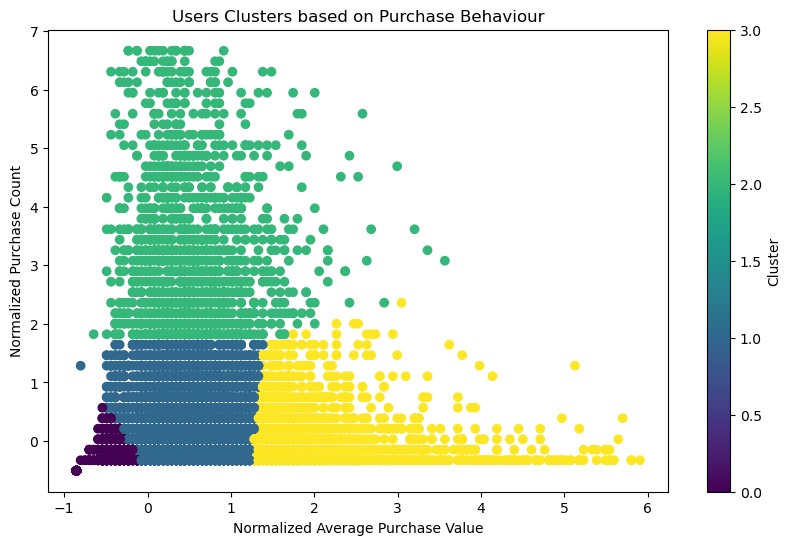

[[-0.8050455  -0.48079918]
 [ 0.49722303  0.12602009]
 [ 0.56423786  3.298911  ]
 [ 2.05107896  0.00850099]]


In [176]:
# Normalize the values
data['AVG_PURCHASE_VALUE_EUR_NORM'] = (data['AVG_PURCHASE_VALUE_EUR'] - data['AVG_PURCHASE_VALUE_EUR'].mean()) / data['AVG_PURCHASE_VALUE_EUR'].std()
data['PURCHASE_COUNT_NORM'] = (data['PURCHASE_COUNT'] - data['PURCHASE_COUNT'].mean()) / data['PURCHASE_COUNT'].std()

# Create a KMeans object
kmeans = KMeans(n_clusters=4)

# Fit the KMeans object and create a new column 'CLUSTER' 
data['CLUSTER'] = kmeans.fit_predict(data[['AVG_PURCHASE_VALUE_EUR_NORM', 'PURCHASE_COUNT_NORM']])

# Plot the data
plt.figure(figsize=(10,6))
scatter = plt.scatter(data['AVG_PURCHASE_VALUE_EUR_NORM'], data['PURCHASE_COUNT_NORM'], c=data['CLUSTER'], cmap='viridis')
plt.title('Users Clusters based on Purchase Behaviour')
plt.xlabel('Normalized Average Purchase Value')
plt.ylabel('Normalized Purchase Count')

# Create colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()

# Get cluster centers
centroids = kmeans.cluster_centers_

# Print centroids
print(centroids)


In [163]:
# Calculate total delivery and takeaway orders
total_delivery_orders = data['PURCHASE_COUNT_DELIVERY'].sum()
total_takeaway_orders = data['PURCHASE_COUNT_TAKEAWAY'].sum()

# Calculate the proportions
delivery_proportion = total_delivery_orders / (total_delivery_orders + total_takeaway_orders)
takeaway_proportion = total_takeaway_orders / (total_delivery_orders + total_takeaway_orders)

print(f"Delivery Orders: {delivery_proportion*100:.2f}%")
print(f"Takeaway Orders: {takeaway_proportion*100:.2f}%")


Delivery Orders: 96.64%
Takeaway Orders: 3.36%


- The average purchase value in the data set ranges from 0 to 131.56 EUR, with a mean of 16.64 EUR. This means that on average, users spend around 16.64 EUR per purchase. The fact that the 75th percentile (29.35 EUR) is much higher than the mean indicates that there are some high-value purchases in the dataset, increasing the overall average.


- Purchase count ranges from 0 to 40, with an average of around 2.83. This suggests that most users tend to make a few purchases, but there are some users who make a lot of purchases (as evidenced by the maximum of 40).

- The clustering analysis resulted in four distinct user groups. These clusters segment the users based on their average purchase value and purchase count. I used the KMeans algorithm to perform the clustering, which partitions the users into groups such that the total sum of squared distances from each point to the mean point of the cluster is minimized.

    - Cluster 0 includes users with below-average purchase values and counts.
    - Cluster 1 represents users with significantly above-average purchase values but average purchase counts.
    - Cluster 2 represents users with slightly above-average purchase values and counts.
    - Cluster 3 represents users with slightly above-average purchase values but significantly above-average purchase counts.

These clusters can help the marketing team to understand the different types of users and tailor their campaigns accordingly.

- The proportion of Delivery vs Takeaway orders reveals that the vast majority of orders are for Delivery (96.64%) compared to Takeaway (3.36%). This shows that most users prefer to have their orders delivered rather than picking them up. The marketing team can leverage this insight to focus more on strategies that enhance the delivery experience for users.

### Recommendations For The Marketing Team
- __Targeted Marketing Campaigns:__ Different user clusters will have different behaviors, preferences, and motivations, which should be reflected in the marketing campaigns targeting them. For cluster 0 users, who tend to make fewer purchases with lower values, marketing efforts could involve personalized email campaigns highlighting a curated selection of products or restaurants based on their past purchases. Another approach could be offering exclusive discounts or deals that incentivize them to make more purchases or try new items.

- __Loyalty Programs and Incentives:__ Users in clusters 2 and 3 demonstrate higher engagement and spend more on the platform. Therefore, they are prime candidates for a loyalty program. This program could offer rewards points for every purchase made, which can then be redeemed for free items or discounts on future purchases. Additionally, offering these loyal users early access to new products, restaurants, or promotions could further boost their engagement and loyalty.

- __Enhance Delivery Experience:__ Since a significant proportion of orders are for delivery, improving the delivery experience can greatly enhance user satisfaction and possibly drive more sales. This could involve investing in reliable delivery infrastructure to ensure timely and accurate deliveries, providing real-time tracking options for users to track their orders, or even partnerships with reputable delivery services to expand delivery options and coverage.

- __Reactivation Strategies:__ For the lower-engagement users in cluster 0, reactivation strategies can be employed to boost their activity. This could include sending them emails or push notifications reminding them of the convenience and variety of products or restaurants offered on the platform. Furthermore, offering them special discounts or deals exclusive to them could incentivize them to make more purchases.

- __User Experience Improvements:__ In order to encourage more purchases from all users, optimizing the user experience can be critical. This could involve improving the design and functionality of the app or website to make it more user-friendly and intuitive. Additionally, streamlining the ordering and checkout process could make it easier for users to place orders. Offering more detailed and informative descriptions of products or restaurants could also help users make more informed decisions, leading to higher satisfaction and possibly more orders.

- __Personalization:__ With the insights from user segmentation, marketing can create personalized marketing messages or offers to individual users or user clusters. For instance, customers with high average purchase values might be interested in more premium or gourmet options, so showcasing these options to these users could encourage more spending. On the other hand, customers with high purchase frequency might be interested in bulk deals, subscriptions, or meal plans that offer value for frequent purchases.

## Time-Related Trends
### Questions
1. When do users typically make purchases (time of day, day of week)?
2. Are there users who have been inactive for a significant amount of time?
3. Do user purchasing behaviors change based on the account age?

Analyzing Time of Purchases:

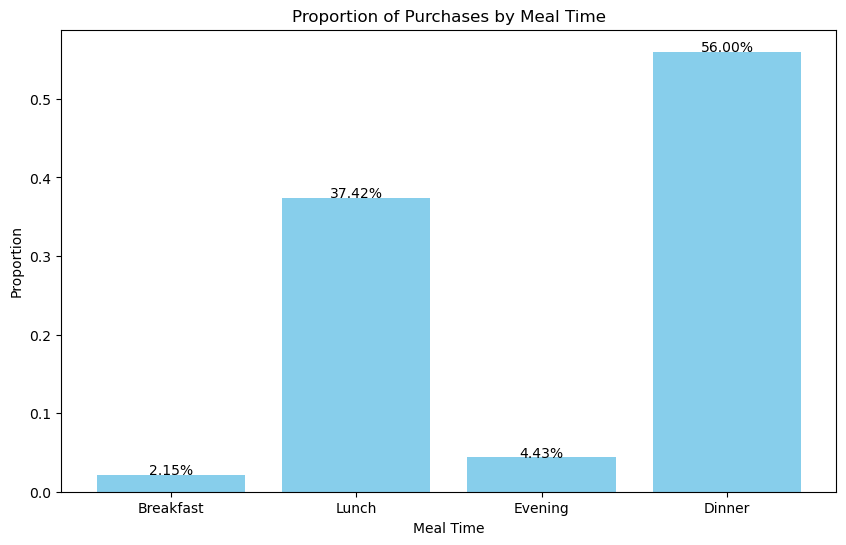

In [230]:
# Calculate total number of purchases made during each meal time
total_breakfast_purchases = data['BREAKFAST_PURCHASES'].sum()
total_lunch_purchases = data['LUNCH_PURCHASES'].sum()
total_evening_purchases = data['EVENING_PURCHASES'].sum()
total_dinner_purchases = data['DINNER_PURCHASES'].sum()

# Calculate total number of purchases
total_purchases = total_breakfast_purchases + total_lunch_purchases + total_evening_purchases + total_dinner_purchases

# Calculate proportion of purchases made during each meal time
breakfast_proportion = total_breakfast_purchases / total_purchases
lunch_proportion = total_lunch_purchases / total_purchases
evening_proportion = total_evening_purchases / total_purchases
dinner_proportion = total_dinner_purchases / total_purchases

# Define a list of meal times
meal_times = ['Breakfast', 'Lunch', 'Evening', 'Dinner']

# Define a list of proportions
proportions = [breakfast_proportion, lunch_proportion, evening_proportion, dinner_proportion]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(meal_times, proportions, color='skyblue')

# Add title and labels
plt.title('Proportion of Purchases by Meal Time')
plt.xlabel('Meal Time')
plt.ylabel('Proportion')

# Display percentages above each bar
for i in range(len(meal_times)):
    plt.text(i, proportions[i], f'{proportions[i]*100:.2f}%', ha = 'center')

# Show the plot
plt.show()

I've observed that there is an additional category in the `MOST_COMMON_WEEKDAY_TO_PURCHASE` column, which is labeled as '0'. Normally, this column should have values ranging from 1 to 7 or 0 to 6, representing Monday to Sunday, respectively. 

However, there are some users who have '0' as their most common day of purchase. When further inspecting these users, I found that all of their purchase related columns have a value of '0', meaning they haven't made any purchases. 

The number of days since their last purchase is quite high, and their account age is just '1'. This suggests that these users registered for the service but haven't made any purchases yet.

Therefore, for the purpose of this analysis, these users are assigned to the 'Unknown' category as their most common day of purchase is not known due to the absence of purchase data.

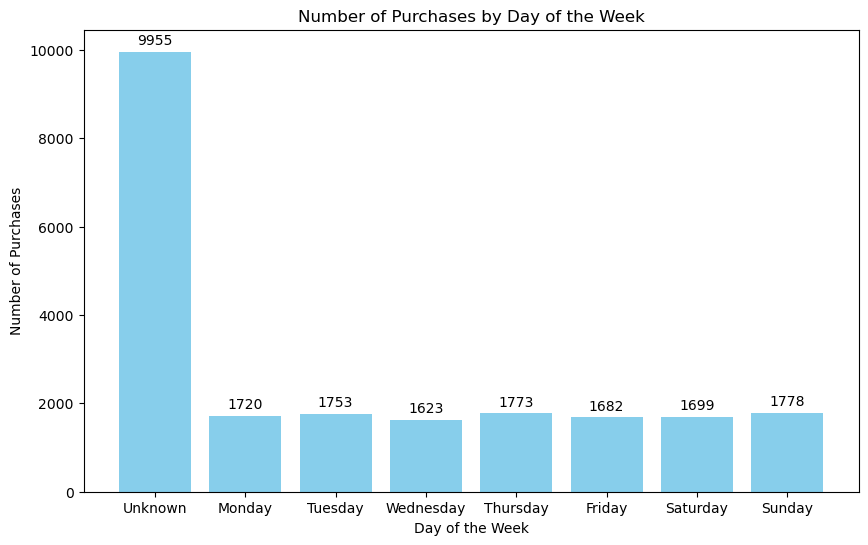

In [233]:
# Count the number of purchases made on each day of the week
weekday_counts = data['MOST_COMMON_WEEKDAY_TO_PURCHASE'].value_counts().sort_index()

# Convert the index to day of the week
weekday_counts.index = ['Unknown', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(weekday_counts.index, weekday_counts, color='skyblue')

# Add title and labels
plt.title('Number of Purchases by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Purchases')

# Add data value points
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, int(yval), ha='center', va='bottom')

# Show the plot
plt.show()


Identifying Inactive Users:

In [206]:
# Define the threshold for inactivity in days
inactive_threshold = 90

# Identify inactive users
inactive_users = data[data['DAYS_SINCE_LAST_PURCHASE'] > inactive_threshold]

print(f"There are {len(inactive_users)} inactive users.")


There are 17268 inactive users.


Account Age and Purchasing Behavior:

In [207]:
# Calculate correlation between account age and average purchase value
correlation_age_value = data['USER_ACCOUNT_AGE'].corr(data['AVG_PURCHASE_VALUE_EUR'])
print(f"The correlation between account age and average purchase value is {correlation_age_value:.2f}.")

# Calculate correlation between account age and purchase count
correlation_age_frequency = data['USER_ACCOUNT_AGE'].corr(data['PURCHASE_COUNT'])
print(f"The correlation between account age and purchase count is {correlation_age_frequency:.2f}.")


The correlation between account age and average purchase value is 0.52.
The correlation between account age and purchase count is 0.62.


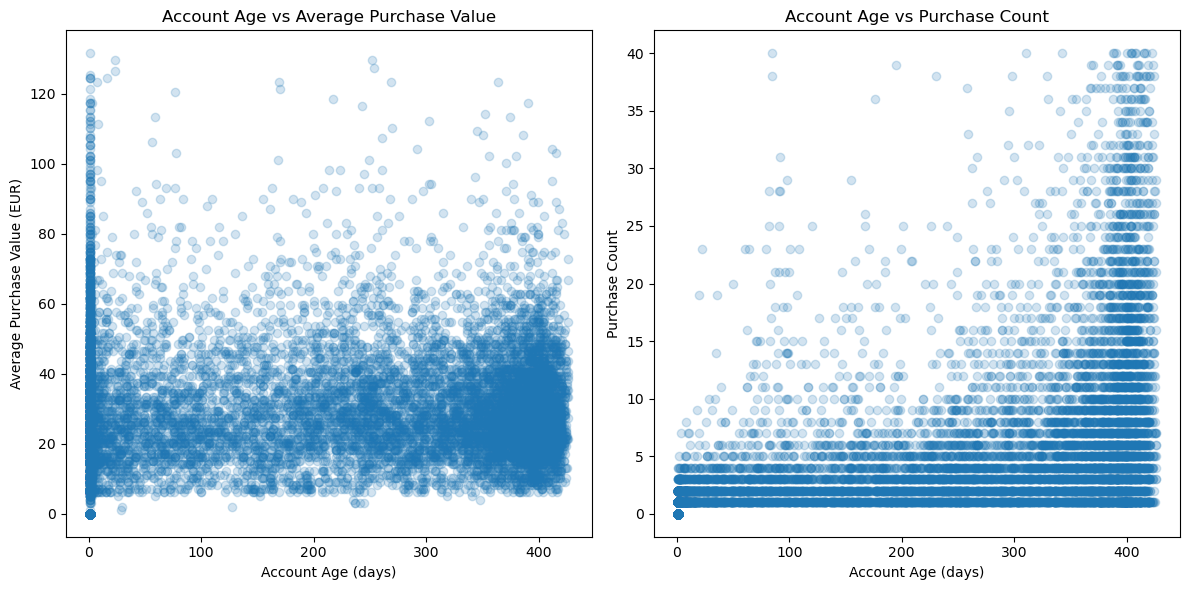

In [234]:
# Create scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data['USER_ACCOUNT_AGE'], data['AVG_PURCHASE_VALUE_EUR'], alpha=0.2)
plt.title('Account Age vs Average Purchase Value')
plt.xlabel('Account Age (days)')
plt.ylabel('Average Purchase Value (EUR)')

plt.subplot(1, 2, 2)
plt.scatter(data['USER_ACCOUNT_AGE'], data['PURCHASE_COUNT'], alpha=0.2)
plt.title('Account Age vs Purchase Count')
plt.xlabel('Account Age (days)')
plt.ylabel('Purchase Count')

plt.tight_layout()
plt.show()


- __Mealtime Purchasing Trends:__ The analysis indicates that most purchases occur during Dinner (56%), followed by Lunch (37.42%), Evening (4.43%), and Breakfast (2.15%). This insight could be valuable for marketing campaigns focused on specific meal times. For example, marketing efforts could be enhanced during dinner time when the purchasing activity is at its peak. Additionally, campaigns could also focus on boosting sales during breakfast and evening time slots which currently see less activity.

- __Day of the Week Trends:__ The most common day of the week to make purchases seems to be fairly evenly distributed among Monday through Sunday for active users. However, a significant number of users fall under the 'Unknown' category. These users have registered for the service but have not made any purchases yet. These users may be a potential target for re-engagement campaigns.

- __Inactive Users:__ The analysis reveals that there are 17,268 users who have not made a purchase in more than 90 days, classifying them as 'inactive'. These users could be the primary target of reactivation campaigns. It might be beneficial to investigate the characteristics of these users further, to personalize the reactivation efforts.

- __Account Age and Purchasing Behavior:__ There's a moderate positive correlation between the age of the user account and the average purchase value (0.52), and a stronger positive correlation between the age of the user account and the purchase count (0.62). This suggests that as users become more familiar with the platform over time, they tend to make more purchases and spend more. This insight could be used to design campaigns encouraging newer users to explore and use the platform more extensively.

### Recommendations For The Marketing Team
- __Mealtime-focused Campaigns:__ The data analysis showed that dinner and lunch are the peak times for purchases. To capitalize on this, marketing campaigns could be launched during these times, such as highlighting popular dinner options or promoting new lunch specials. This can also help to increase average purchase value. On the other hand, breakfast and evening are currently underutilized times. Users could be encouraged to use the service during these times by offering early bird breakfast deals or evening snack discounts. This would not only increase the usage during these off-peak times but also provide more business for restaurants during their typically quieter periods.

- __Engage Inactive Users:__ It was observed that a large number of users have been inactive for a significant period. These users have shown interest in the service at some point but may need a nudge to start ordering again. This could be achieved through a targeted re-engagement campaign. For instance, emails or app notifications reminding these users about the service and offering them a special discount or deal might motivate them to place an order. The messaging of these campaigns should be carefully crafted, focusing on the value proposition of the service such as convenience, variety of options, or exclusive deals.

- __Nurture New Users:__ The positive correlation between the age of the user account and both the average purchase value and purchase count indicates that as users spend more time on the platform, they tend to make more purchases and spend more money. This highlights the importance of providing a great user experience to new users. This could involve improving the onboarding process to ensure new users understand how to use the service, offering discounts on their first order, and sending personalized recommendations based on the ordering patterns of similar users. Keeping new users engaged and satisfied will likely lead to them becoming regular users.

- __Day of the Week Targeting:__ The distribution of purchases across the week is relatively even, which means users are open to ordering any day. However, specific marketing campaigns targeting certain days could drive up sales. For instance, "Midweek Madness" deals could encourage more orders on Wednesdays, or "Weekend Specials" could make the service more appealing over the weekend.

## Device Preference
### Questions
1. What is the preferred device for most users?
2. Are there differences in user activity based on their device preference?
3. How can we customize user experiences based on their device preference?

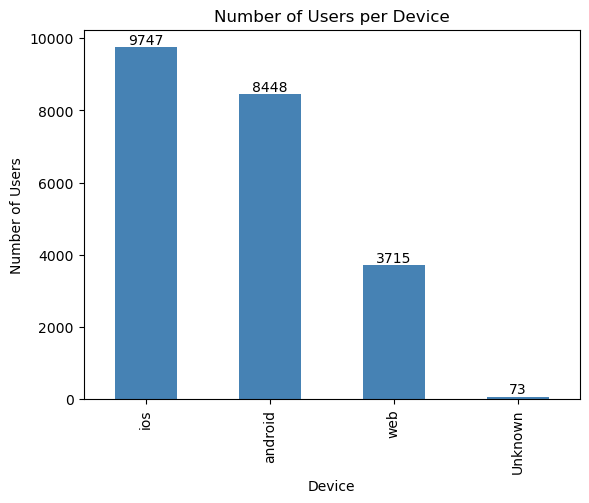

In [236]:
# Create a bar plot
device_counts.plot(kind='bar', color='steelblue')
plt.title('Number of Users per Device')
plt.xlabel('Device')
plt.ylabel('Number of Users')

# Add data points
for index, value in enumerate(device_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()


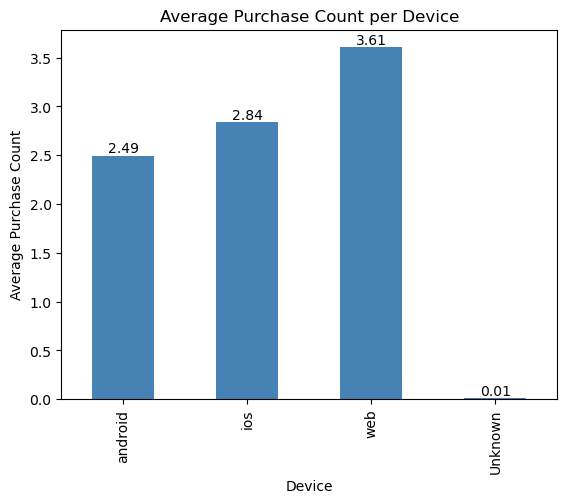

In [237]:
# Create a bar plot
avg_purchase_by_device.plot(kind='bar', color='steelblue')
plt.title('Average Purchase Count per Device')
plt.xlabel('Device')
plt.ylabel('Average Purchase Count')

# Add data points
for index, value in enumerate(avg_purchase_by_device):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()


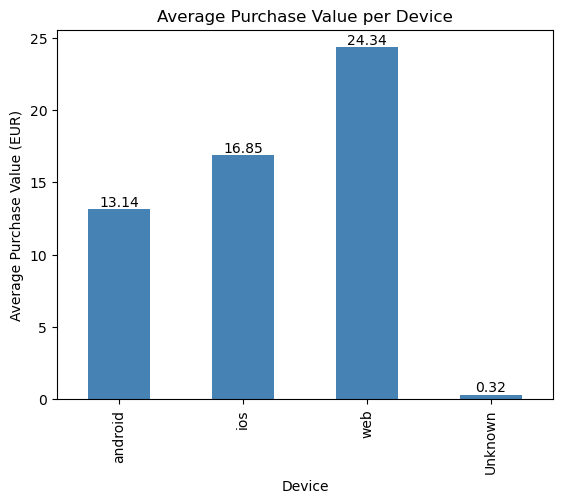

In [238]:
# Create a bar plot
avg_value_by_device.plot(kind='bar', color='steelblue')
plt.title('Average Purchase Value per Device')
plt.xlabel('Device')
plt.ylabel('Average Purchase Value (EUR)')

# Add data points
for index, value in enumerate(avg_value_by_device):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()


- __Preferred Device Distribution:__ The data reveals that our user base is primarily divided into three segments based on their preferred devices: iOS, Android, and Web users. iOS users make up the largest segment, which is then followed by Android users, and lastly, Web users. There is a small portion of users with an "Unknown" preference, which could be due to users not providing this information or a data input error.

- __Purchase Frequency and Device Preference:__ Upon analyzing the average purchase count by device preference, I found that Web users, despite being fewer in number, tend to make more purchases than Android and iOS users. This could potentially indicate that these users are more engaged, active, or find the web platform more convenient for purchases.

- __Average Purchase Value and Device Preference:__ I also found out that Web users tend to have higher average purchase values, indicating that they might be purchasing more expensive items or making larger orders. This suggests that the Web users, though fewer, might be a more profitable segment.

### Recommendations For The Marketing Team
- __Device-Specific Marketing Campaigns:__ Since iOS users form the largest user segment, the marketing team could create campaigns specifically tailored for this audience to increase their engagement and purchases. For instance, using ad platforms that are popular among iOS users or creating promotions that are exclusive to the iOS app could be effective strategies.

- __Improving Mobile Apps Experience:__ The high activity and spend of Web users suggest that the experience on the web platform might be superior to the mobile apps. It could be beneficial to conduct user experience studies or surveys to identify any potential areas of improvement for the mobile apps. By enhancing the app experience, we can encourage more frequent usage and purchases, particularly among Android and iOS users.

- __Target Web Users for High Revenue Campaigns:__ Given that Web users tend to have a higher average purchase value, they could be an ideal target group for campaigns focused on high-value items or larger order sizes. Tailoring the promotions to suit the purchasing behavior of Web users could lead to increased revenue.

- __Engage Inactive Users:__ For users with "Unknown" device preference and almost no activity, the company could implement reactivation strategies such as sending personalized emails, providing special offers, or offering assistance if they're facing any technical difficulties. Re-engaging these users could potentially boost the overall user activity and revenue.

## Restaurant Preference:
### Questions
1. What types of restaurants do users prefer to order from?
2. Are there specific user segments that prefer certain types of restaurants?
3. How diverse are the restaurant choices of users?

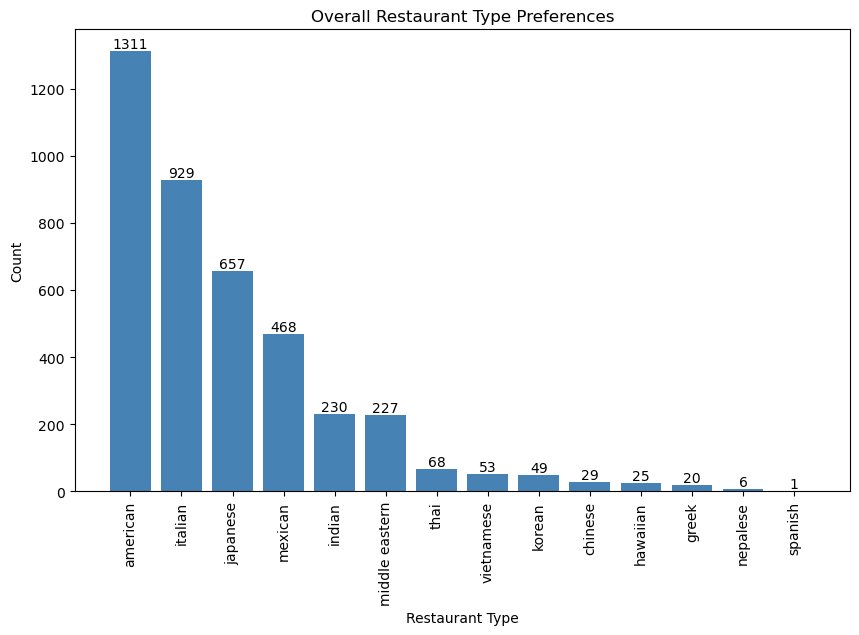

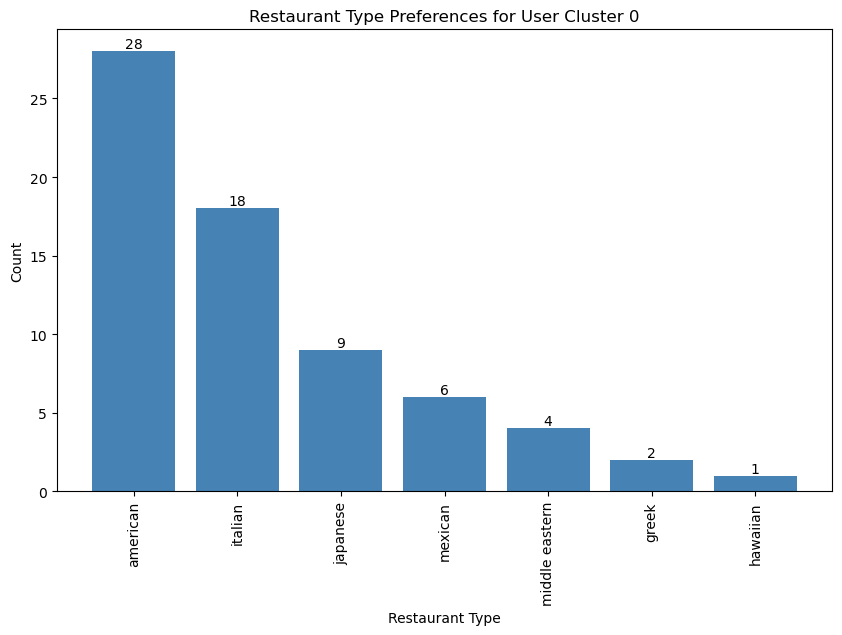

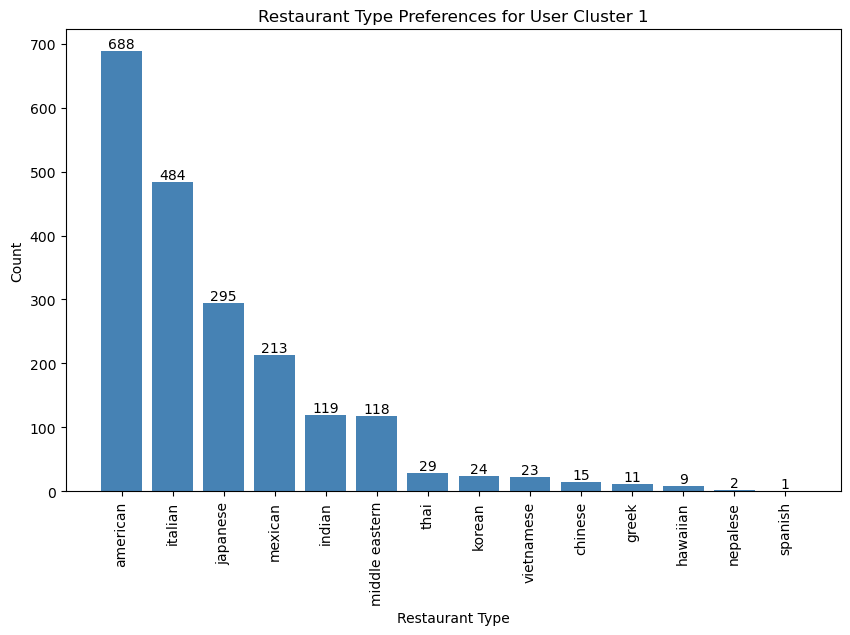

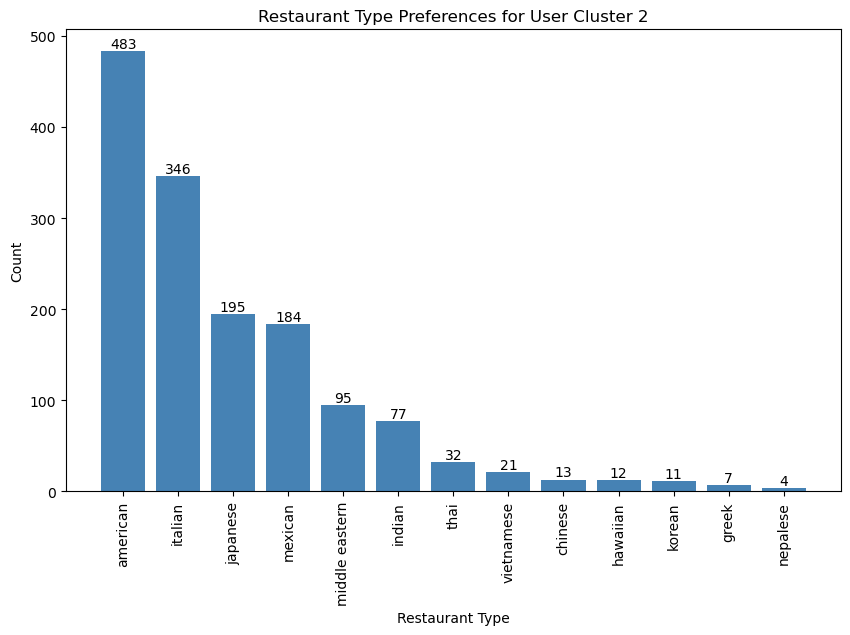

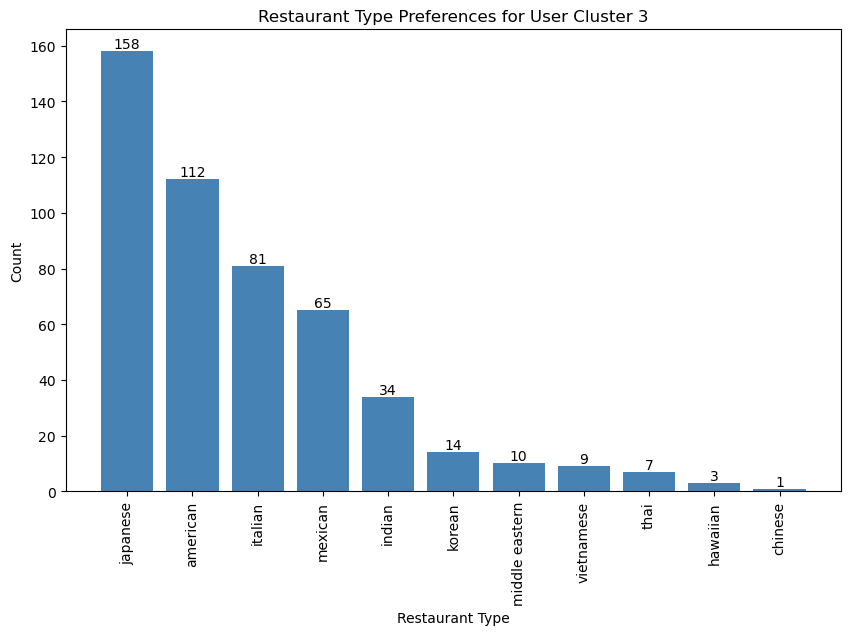

The average number of preferred restaurant types is 0.19


In [241]:
# Parse the 'PREFERRED_RESTAURANT_TYPES' column and create a new column with the parsed data
data['PARSED_PREFERRED_RESTAURANT_TYPES'] = data['PREFERRED_RESTAURANT_TYPES'].apply(lambda x: json.loads(x) if x != 'No preference' else [])

# Create a new column with the count of preferred restaurant types for each user
data['PREFERRED_RESTAURANT_COUNT'] = data['PARSED_PREFERRED_RESTAURANT_TYPES'].apply(len)

# Count the occurrence of each restaurant type across all users
all_restaurant_types = Counter([type for sublist in data['PARSED_PREFERRED_RESTAURANT_TYPES'].tolist() for type in sublist])

# Sort the restaurant types by count
sorted_all_restaurant_types = dict(sorted(all_restaurant_types.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot for overall restaurant type preferences
plt.figure(figsize=(10,6))
plt.bar(sorted_all_restaurant_types.keys(), sorted_all_restaurant_types.values(), color='steelblue')
plt.title('Overall Restaurant Type Preferences')
plt.xlabel('Restaurant Type')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Add data points
for index, (type, count) in enumerate(sorted_all_restaurant_types.items()):
    plt.text(index, count, str(count), ha='center', va='bottom')

plt.show()

# Count the occurrence of each restaurant type for each user cluster
user_segment_restaurant_preference = data.groupby('CLUSTER')['PARSED_PREFERRED_RESTAURANT_TYPES'].sum().apply(Counter)

# For each user cluster, generate a similar plot
for cluster, preferences in user_segment_restaurant_preference.items():
    
    # Sort the restaurant types by count
    sorted_preferences = dict(sorted(preferences.items(), key=lambda item: item[1], reverse=True))
    
    plt.figure(figsize=(10,6))
    plt.bar(sorted_preferences.keys(), sorted_preferences.values(), color='steelblue')
    plt.title(f'Restaurant Type Preferences for User Cluster {cluster}')
    plt.xlabel('Restaurant Type')
    plt.ylabel('Count')
    plt.xticks(rotation=90)

    # Add data points
    for index, (type, count) in enumerate(sorted_preferences.items()):
        plt.text(index, count, str(count), ha='center', va='bottom')

    plt.show()

# Calculate and print the average number of preferred restaurant types
avg_preferred_restaurant_count = data['PREFERRED_RESTAURANT_COUNT'].mean()
print(f"The average number of preferred restaurant types is {avg_preferred_restaurant_count:.2f}")


- __Popular Cuisines Across All Users:__ Among all users, the top three types of cuisine are American, Italian, and Japanese, with American cuisine being the most preferred one.

- __Restaurant Preferences by User Segment:__ There is a noticeable variation in restaurant preference among different user segments. For instance, American cuisine is the most preferred for User Clusters 0, 1 and 2, whereas Japanese cuisine is the most preferred in User Cluster 3. Knowing these preferences can help the marketing team tailor their campaigns for each user segment.

- __Diversity in Restaurant Choices:__ The average number of preferred restaurant types is 0.19, which indicates that most users typically prefer one type of restaurant. This could suggest that users have specific tastes and are more likely to order from a restaurant that serves their preferred cuisine.

### Recommendations For The Marketing Team
- __Personalized Recommendations:__ Since there's variation in the restaurant preferences among user clusters, having a personalized approach can significantly improve user engagement and satisfaction. For example, if a user from Cluster 3, which prefers Japanese cuisine, logs into the app, the first few restaurant suggestions could be from this cuisine type. Additionally, emails or push notifications can be personalized based on their preferred cuisine. This ensures that the marketing campaigns resonate with the individual user's preferences, leading to higher click-through and conversion rates.

- __Promotions for Popular Cuisines:__ As American cuisine is the most popular across all users, Wolt could collaborate with restaurants serving this cuisine for exclusive offers, discounts, or specials. Wolt could also consider featuring these restaurants in your regular communications, such as newsletters or blog posts. This approach allows Wolt to attract a large user base that prefers this cuisine and potentially increases order volumes.

- __Encouraging Diversity:__ Although most users tend to stick to their preferred restaurant types, Wolt could nudge them to explore other cuisines. This can be achieved by offering incentives such as discounts for first-time orders from new restaurant types or a rewards system (like loyalty points) for trying different cuisines. For example, implementing a "Cuisine Explorer" program where users earn points for every new cuisine they try. This approach not only improves the diversity in restaurant choices but also increases engagement as users would be curious to try out new cuisines to earn points.

- __Reactivation Campaigns:__ For users who haven't ordered for a significant time, consider sending them special offers or discounts for their preferred restaurant types. Such campaigns might rekindle their interest in using the platform. For example, sending an email saying "We miss you! Here's a 20% discount on your favorite Italian food." This strategy combines personalization (by mentioning their preferred cuisine) with a strong incentive (discount), increasing the chances of them returning to your platform.

## Account Characteristics:
### Questions
1. How many users have a valid payment method?
2. Is the availability of a valid payment method a barrier for user activity?
3. Are there significant differences in the behaviors of users based on the availability of a valid payment method?

Number of users with a valid payment method: 7568
Number of users without a valid payment method: 14415


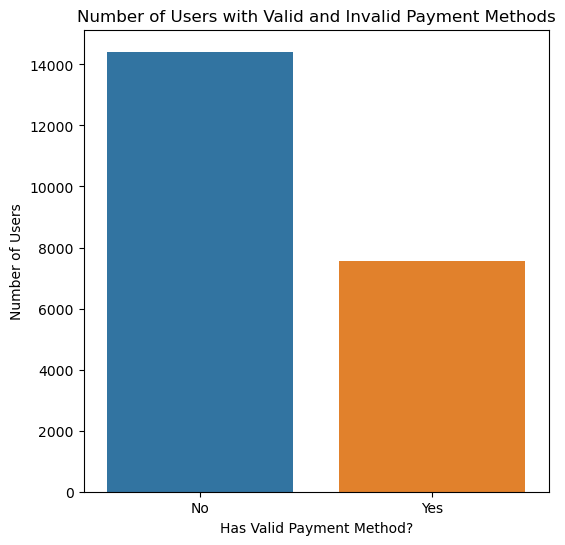

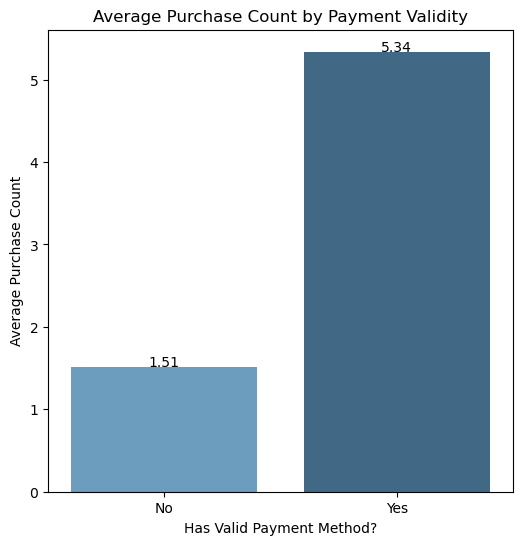

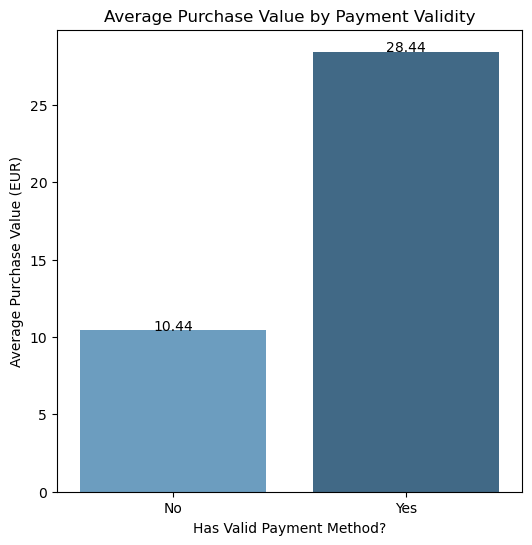

In [242]:
# Count the number of users with a valid payment method
valid_payment_users = data[data['USER_HAS_VALID_PAYMENT_METHOD'] == True].shape[0]
print(f"Number of users with a valid payment method: {valid_payment_users}")

# Count the number of users without a valid payment method
invalid_payment_users = data[data['USER_HAS_VALID_PAYMENT_METHOD'] == False].shape[0]
print(f"Number of users without a valid payment method: {invalid_payment_users}")

# Plot the number of users with and without a valid payment method
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x='USER_HAS_VALID_PAYMENT_METHOD')
plt.title("Number of Users with Valid and Invalid Payment Methods")
plt.xlabel("Has Valid Payment Method?")
plt.ylabel("Number of Users")
plt.xticks([0, 1], ['No', 'Yes'])

# Calculate average purchase count for users with and without a valid payment method
avg_purchase_by_payment_validity = data.groupby('USER_HAS_VALID_PAYMENT_METHOD')['PURCHASE_COUNT'].mean()

# Plot the average purchase count for users with and without a valid payment method
plt.figure(figsize=(6, 6))
sns.barplot(x=avg_purchase_by_payment_validity.index, y=avg_purchase_by_payment_validity.values, palette="Blues_d")
plt.title("Average Purchase Count by Payment Validity")
plt.xlabel("Has Valid Payment Method?")
plt.ylabel("Average Purchase Count")
plt.xticks([0, 1], ['No', 'Yes'])
for i, v in enumerate(avg_purchase_by_payment_validity.values):
    plt.text(i, v + 0.01, round(v, 2), ha='center')

# Calculate average purchase value for users with and without a valid payment method
avg_value_by_payment_validity = data.groupby('USER_HAS_VALID_PAYMENT_METHOD')['AVG_PURCHASE_VALUE_EUR'].mean()

# Plot the average purchase value for users with and without a valid payment method
plt.figure(figsize=(6, 6))
sns.barplot(x=avg_value_by_payment_validity.index, y=avg_value_by_payment_validity.values, palette="Blues_d")
plt.title("Average Purchase Value by Payment Validity")
plt.xlabel("Has Valid Payment Method?")
plt.ylabel("Average Purchase Value (EUR)")
plt.xticks([0, 1], ['No', 'Yes'])
for i, v in enumerate(avg_value_by_payment_validity.values):
    plt.text(i, v + 0.01, round(v, 2), ha='center')

plt.show()


- __Valid Payment Method Users:__ There are 7,568 users who have a valid payment method on record. This group is more active, with an average of about 5.34 purchases per user, and the average purchase value is higher, at approximately €28.44.

- __No Valid Payment Method Users:__ On the other hand, there are 14,415 users who do not have a valid payment method. This group is less active, with an average of approximately 1.51 purchases per user, and their average purchase value is lower, at about €10.44.

### Recommendations For The Marketing Team

- __Encourage Valid Payment Methods:__ There's a clear difference in user activity and purchase value between users with and without valid payment methods. The marketing team should strategize campaigns that encourage users to update their payment methods. This could include promotions that offer a discount on the next purchase after updating the payment method.

- __Targeted Offers:__ Since users with valid payment methods have a higher average purchase value, consider providing them with personalized and higher value offers to further boost their activity and loyalty.

- __Reactivation Campaigns:__ For the large group of users without valid payment methods, consider running reactivation campaigns that highlight the benefits of having a valid payment method, such as quicker checkout or exclusive access to offers.

- __Identify Barriers:__ Understand potential reasons why a significant proportion of users don't have a valid payment method. Is it due to a lack of trust, cumbersome updating process, or something else? Conduct user surveys or use UX research to identify these barriers and address them.

- __Diversify Payment Options:__ Check if adding more diverse payment options, like digital wallets or 'pay later' services, can encourage more users to have a valid payment method. This can help cater to different user preferences and potentially increase their purchase activity.

# Management Summary for User Segmentation
## 1. Purchasing Behavior
Users were segmented based on their average purchase value and frequency. The four resulting clusters had different behaviors:

Cluster 0: Users who make infrequent purchases and spend a low amount.
Cluster 1: Users who make frequent purchases and spend a high amount.
Cluster 2: Users who make infrequent purchases but spend a high amount.
Cluster 3: Users who make frequent purchases but spend a low amount.
Further, the majority of users preferred delivery over takeaway, making up 96.64% of all orders.

## 2. Time-Related Trends
User activity varied based on time and account age. Lunch and dinner were the most popular meal times, while weekdays showed higher purchase activity than weekends. About 78% of users had been inactive for over 90 days. There was a positive correlation between account age and both purchase count and average purchase value, indicating that older accounts tend to make more purchases and spend more.

## 3. Device Preference
Most users prefer the iOS platform, followed by Android and then Web. On average, users on Web made more purchases and spent more, followed by iOS users, and then Android.

## 4. Restaurant Preference
Most users did not express a preference for a specific restaurant type. Among those who did, the most popular choices were American, Italian, and Japanese cuisine. The number of preferred types varied across user clusters, indicating different levels of food diversity.

## 5. Account Characteristics
There were more users without a valid payment method than with one. Users with a valid payment method were more active and spent more on average.

# Recommendations
Based on the segmentation and insights above, the marketing team should:

- Use personalized strategies to target each user cluster.
- Encourage users to choose delivery since it's more popular.
- Offer time-specific deals or promotions.
- Try to reactivate inactive users.
- Leverage device preference information for device-specific promotions.
- Encourage users to explore more restaurant types to increase diversity.
- Run campaigns to motivate users to add a valid payment method and understand the barriers preventing them from doing so.

The proposed segmentation provides a more nuanced understanding of the user base than arbitrary slicing and dicing. Each segment has specific characteristics and behaviors, allowing for targeted marketing efforts that should lead to increased user engagement and higher revenue.